In [1]:
import os
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.8'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
import jax
import flax
import jax.numpy as jnp
import flax.linen as nn
import wandb

import time
from functools import partial

import numpy as np
from matplotlib import pyplot as plt

print('Jax version', jax.__version__)
print('Flax version', flax.__version__)
random_key = jax.random.PRNGKey(0)

Jax version 0.4.1
Flax version 0.5.1


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
wandb.init(project="brain", entity="glow-jax")
config = wandb.config
config.batch_size = 128
config.learning_rate = 1e-3
config.epochs = 30

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: youngbinkoko (glow-jax). Use `wandb login --relogin` to force relogin


# Data

In [4]:
import glob
import tensorflow as tf
import tensorflow_datasets as tfds
# tf.config.experimental.set_visible_devices([], 'GPU')
import matplotlib.pyplot as plt
import einops
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from pathlib import Path

2023-02-24 15:57:40.255887: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-24 15:57:40.256018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-24 15:57:40.256030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/dhc/home/youngbin.ko/conda3/envs/glowenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autono

In [ ]:
def map_fn(image, num_bits=5, size=256, training=True):
    """Transform the image data and quantize.
    If num_bits = 8, there is no quantization effect."""
    # Resize input image
    image = tf.cast(image, tf.float32)
    # tf.make_ndarray(image)
    image = tf.image.resize(image, (size, size))
    image = tf.clip_by_value(image, 0., 255.)
    # Discretize to the given number of bits
    if num_bits < 8:
        image = tf.floor(image / 2 ** (8 - num_bits))
    # Send to [-1, 1]
    num_bins = 2 ** num_bits
    image = image / num_bins - 0.5
    if training:
        image = image + tf.random.uniform(tf.shape(image), 0, 1. / num_bins)
    return image


In [ ]:
def get_train_dataset(image_path, image_size, num_bits, batch_size, **kwargs):
    del kwargs
    empty_tensor = tf.constant([], dtype=tf.float32)
    train_ds = tf.data.Dataset.from_tensor_slices(empty_tensor)
    file_paths = glob.glob(f"{image_path}/*.npy")
    np.random.shuffle(file_paths)
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        slices_path = os.path.join('/dhc/home/youngbin.ko/glow_brain/data/slices_train_64', f'{filename.split(".")[0]}_slices.npy')
        if os.path.exists(slices_path):
                # If slices already exist, load and concatenate them to the train_ds
                slices = np.load(slices_path)
                slices_dataset = tf.data.Dataset.from_tensor_slices(slices)
                train_ds = train_ds.concatenate(slices_dataset)
        else:
            # If slices do not exist, generate them and save them to slices_path
            slices_dataset = generate_slices_npy(file_path, image_size, num_bits, True)
            train_ds = train_ds.concatenate(slices_dataset)

    num_elements = train_ds.cardinality().numpy()
    print("Number of elements in train_ds:", num_elements/155)    
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.repeat()
    return iter(tfds.as_numpy(train_ds))

# to save slices in .npy format
def generate_slices_npy(file_path, image_size, num_bits, training):
    img = np.load(file_path)
    dir_path, filename = os.path.split(file_path)
    if img.shape[0] == 0:
        return tf.data.Dataset.from_tensor_slices([])
    img = einops.rearrange(img, 'm h w s -> s h w m')
    slices = []
    for slice in range(img.shape[0]):
        slices.append(img[slice, :, :, :])
    slices_dataset = tf.data.Dataset.from_tensor_slices(slices)
    slices_ds = slices_dataset.map(partial(map_fn, size=image_size, num_bits=num_bits, training=training))
    # output_dir = os.path.join(dir_path, 'slices')
    # os.makedirs(output_dir, exist_ok=True)
    #output_path = os.path.join('/dhc/home/youngbin.ko/glow_brain/data/slices_train_64', f'{filename.split(".")[0]}_slices.npy')
    output_path = os.path.join('/dhc/home/youngbin.ko/glow_brain/data/slice_val_128', f'{filename.split(".")[0]}_slices.npy')
    slices_array = np.array(list(slices_ds.as_numpy_iterator()))
    np.save(output_path, slices_array)

    return slices_ds

In [5]:
#after creating slices.npy use this function
def get_train_dataset(image_path, image_size, num_bits, batch_size, **kwargs):
    del kwargs
    empty_tensor = tf.constant([], dtype=tf.float32)
    train_ds = tf.data.Dataset.from_tensor_slices(empty_tensor)
    file_paths = glob.glob(f"{image_path}/*.npy")
    np.random.shuffle(file_paths)
    #train_file_paths = file_paths[:200]
    for file_path in file_paths:
        slices = np.load(file_path)
        slices_dataset = tf.data.Dataset.from_tensor_slices(slices)
        train_ds = train_ds.concatenate(slices_dataset)
    ds_list = list(train_ds)
    np.random.shuffle(ds_list)
    train_ds = tf.data.Dataset.from_tensor_slices(ds_list)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.repeat()
    num_elements = train_ds.cardinality().numpy()
    print("Number of elements in train_ds:", num_elements)
    return iter(tfds.as_numpy(train_ds))

def get_val_dataset(image_path, image_size, num_bits, batch_size, **kwargs):
    del kwargs
    empty_tensor = tf.constant([], dtype=tf.float32)
    valid_ds = tf.data.Dataset.from_tensor_slices(empty_tensor)
    file_paths = glob.glob(f"{image_path}/*.npy")

    for file_path in file_paths:
        slices = np.load(file_path)
        slices_dataset = tf.data.Dataset.from_tensor_slices(slices)
        valid_ds = valid_ds.concatenate(slices_dataset)
    valid_ds = valid_ds.batch(batch_size)
    num_elements = valid_ds.cardinality().numpy()
    print("Number of elements in valid_ds:", num_elements)
    return iter(tfds.as_numpy(valid_ds))

In [6]:
train_dataset = get_train_dataset('/dhc/home/youngbin.ko/glow_brain/data/slices_train_64', 64, 8, 128)
val_dataset = get_val_dataset('/dhc/home/youngbin.ko/glow_brain/data/slices_val_64', 64, 8, 128)

2023-02-24 15:57:45.918416: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-02-24 15:57:45.918514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-02-24 15:57:45.918576: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-02-24 15:57:45.918632: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2023-02-24 15:57:45.918688: W tensorfl

Number of elements in train_ds: -1
Number of elements in valid_ds: 37


In [ ]:
img = next(train_dataset)
print(img.shape)
plt.imshow(img[15,:, :, :])
plt.show()

In [ ]:
def get_val_dataset(image_path, image_size, num_bits, batch_size, take=None, repeat=False, **kwargs):
    del kwargs
    empty_tensor = tf.constant([], dtype=tf.float32)
    valid_ds = tf.data.Dataset.from_tensor_slices(empty_tensor)
    file_paths = glob.glob(f"{image_path}/*.npy")

    for file_path in file_paths:
        filename = os.path.basename(file_path)
        slices_path = os.path.join('/dhc/home/youngbin.ko/glow_brain/data/slice_val_128', f'{filename.split(".")[0]}_slices.npy')
        slices_dataset = generate_slices_npy(file_path, image_size, num_bits, False)
        valid_ds = valid_ds.concatenate(slices_dataset)

    #val_ds = tf.data.Dataset.from_tensor_slices(slices)
    #valid_ds = valid_ds.map(partial(map_fn, size=image_size, num_bits=num_bits, training=False))
    valid_ds = valid_ds.batch(batch_size)
    if repeat:
        valid_ds = valid_ds.repeat()
    return iter(tfds.as_numpy(valid_ds))

In [ ]:
#train_dataset = get_train_dataset('/dhc/home/youngbin.ko/glow_brain/data/train', 256, 8, 32)
val_dataset = get_val_dataset('/dhc/home/youngbin.ko/glow_brain/data/val', 128, 8, 128)

In [ ]:
img = next(val_dataset)
print(img.shape)
plt.imshow(img[5,:, :, :], cmap='gray')
plt.show()

# Train

In [7]:
from layers import squeeze, unsqueeze
from layers import Split
from layers import ActNorm, Conv1x1, AffineCoupling

from model import FlowStep, GLOW

from utils import summarize_jax_model
from utils import plot_image_grid

In [8]:
@jax.vmap
def get_logpz(z, priors):
    logpz = 0
    for zi, priori in zip(z, priors):
        if priori is None:
            mu = jnp.zeros(zi.shape)
            logsigma = jnp.zeros(zi.shape)
        else:
            mu, logsigma = jnp.split(priori, 2, axis=-1)
        logpz += jnp.sum(- logsigma - 0.5 * jnp.log(2 * jnp.pi) 
                         - 0.5 * (zi - mu) ** 2 / jnp.exp(2 * logsigma))
    return logpz

@jax.jit
def postprocess(x, num_bits):
    """Map [-0.5, 0.5] quantized images to uint space"""
    num_bins = 2 ** num_bits
    x = jnp.floor((x + 0.5) * num_bins)
    x *= 256. / num_bins

def sample(model, 
           params, 
           eps=None, 
           shape=None, 
           sampling_temperature=1.0, 
           key=jax.random.PRNGKey(10),
           postprocess_fn=None, 
           save_path=None,
           display=True):
    """Sampling only requires a call to the reverse pass of the model"""
    if eps is None:
        zL = jax.random.normal(key, shape) 
    else: 
        zL = eps[-1]
    y, *_ = model.apply(params, zL, eps=eps, sampling_temperature=sampling_temperature, reverse=True)
    if postprocess_fn is not None:
        y = postprocess_fn(y)
    plot_image_grid(y, save_path=save_path, display=display,
                    title=None if save_path is None else save_path.rsplit('.', 1)[0].rsplit('/', 1)[-1])
    return y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

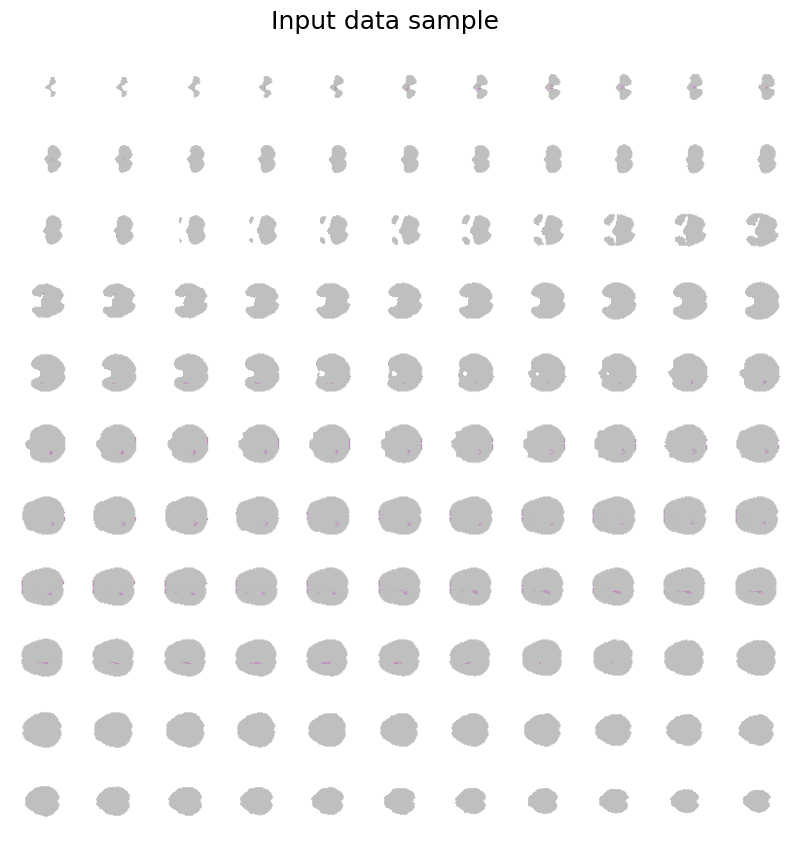

In [8]:
plot_image_grid(next(val_dataset),title="Input data sample")


In [9]:
def train_glow(train_ds,
               val_ds=None,
               num_samples=9,
               image_size=64,
               num_channels=4,
               num_bits=8,
               init_lr=1e-3,
               num_epochs=1,
               num_sample_epochs=1,
               num_warmup_epochs=10,
               num_save_epochs=1,
               steps_per_epoch=416,
               K=32,
               L=3,
               nn_width=512,
               sampling_temperature=0.7,
               learn_top_prior=True,
               key=jax.random.PRNGKey(0),
               **kwargs):
    """Simple training loop.
    Args:
        train_ds: Training dataset iterator (e.g. tensorflow dataset) 70%
        val_ds: Validation dataset (optional) 30%
        num_samples: Number of samples to generate at each epoch
        image_size: Input image size
        num_channels: Number of channels in input images
        num_bits: Number of bits for discretization
        init_lr: Initial learning rate (Adam)
        num_epochs: Numer of training epochs
        num_sample_epochs: Visualize sample at this interval
        num_warmup_epochs: Linear warmup of the learning rate to init_lr
        num_save_epochs: save mode at this interval
        steps_per_epochs: Number of steps per epochs
        K: Number of flow iterations in the GLOW model
        L: number of scales in the GLOW model
        nn_width: Layer width in the Affine Coupling Layer
        sampling_temperature: Smoothing temperature for sampling from the 
            Gaussian priors (1 = no effect)
        learn_top_prior: Whether to learn the prior for highest latent variable zL.
            Otherwise, assumes standard unit Gaussian prior
        key: Random seed
    """
    del kwargs
    # Init model
    model = GLOW(K=K,
                 L=L, 
                 nn_width=nn_width, 
                 learn_top_prior=learn_top_prior,
                 key=key)
    
    # Init optimizer and learning rate schedule
    params = model.init(random_key, next(train_ds))
    opt = flax.optim.Adam(learning_rate=init_lr).create(params)
    
    def lr_warmup(step):
        return init_lr * jnp.minimum(1., step / (num_warmup_epochs * steps_per_epoch + 1e-8))
    
    # Helper functions for training
    bits_per_dims_norm = np.log(2.) * num_channels * image_size**2
    @jax.jit
    def get_logpx(z, logdets, priors):
        logpz = get_logpz(z, priors)
        logpz = jnp.mean(logpz) / bits_per_dims_norm        # bits per dimension normalization
        logdets = jnp.mean(logdets) / bits_per_dims_norm
        logpx = logpz + logdets - num_bits                  # num_bits: dequantization factor
        return logpx, logpz, logdets
        
    @jax.jit
    def train_step(opt, batch):
        def loss_fn(params):
            _, z, logdets, priors = model.apply(params, batch, reverse=False)
            logpx, logpz, logdets = get_logpx(z, logdets, priors)
            return - logpx, (logpz, logdets)
        logs, grad = jax.value_and_grad(loss_fn, has_aux=True)(opt.target)
        opt = opt.apply_gradient(grad, learning_rate=lr_warmup(opt.state.step))
        return logs, opt
    
    # Helper functions for evaluation 
    @jax.jit
    def eval_step(params, batch):
        _, z, logdets, priors = model.apply(params, batch, reverse=False)
        return - get_logpx(z, logdets, priors)[0]
    
    # Helper function for sampling from random latent fixed during training for comparison
    eps = []
    if not os.path.exists("samples"): os.makedirs("samples")
    if not os.path.exists("weights"): os.makedirs("weights")
    for i in range(L):
        expected_h = image_size // 2**(i + 1)
        expected_c = num_channels * 2**(i + 1)
        if i == L - 1: expected_c *= 2
        eps.append(jax.random.normal(key, (num_samples, expected_h, expected_h, expected_c)))
    sample_fn = partial(sample, eps=eps, key=key, display=False,
                        sampling_temperature=sampling_temperature)
    
    # Train
    print("Start training...")
    print("Available jax devices:", jax.devices())
    print()
    bits = 0.
    start = time.time()
    try:
        for epoch in range(num_epochs):
            # train
            for i in range(steps_per_epoch):
                batch = next(train_ds)
                loss, opt = train_step(opt, batch)
                print(f"\r\033[92m[Epoch {epoch + 1}/{num_epochs}]\033[0m"
                      f"\033[93m[Batch {i + 1}/{steps_per_epoch}]\033[0m"
                      f" loss = {loss[0]:.5f},"
                      f" (log(p(z)) = {loss[1][0]:.5f},"
                      f" logdet = {loss[1][1]:.5f})", end='')
                if np.isnan(loss[0]):
                    print("\nModel diverged - NaN loss")
                    return None, None
                
                step = epoch * steps_per_epoch + i + 1
                if step % int(num_sample_epochs * steps_per_epoch) == 0:
                    sample_fn(model, opt.target, 
                              save_path=f"samples/step_{step:05d}.png")
                    # print(opt.target)
                    # print(type(opt.target))
                    # wandb.log({
                    #     "image": wandb.Image(sample_fn)
                    # }, step=step)

            # eval on one batch of validation samples 
            # + generate random sample
            t = time.time() - start
            if val_ds is not None:
                bits = eval_step(opt.target, next(val_ds))
            print(f"\r\033[92m[Epoch {epoch + 1}/{num_epochs}]\033[0m"
                  f"[{int(t // 3600):02d}h {int((t % 3600) // 60):02d}mn]"
                  f" train_bits/dims = {loss[0]:.3f},"
                  f" val_bits/dims = {bits:.3f}" + " " * 50)
            
            # Save parameters
            if (epoch + 1) % num_save_epochs == 0 or epoch == num_epochs - 1:
                with open(f'weights/model_epoch={epoch + 1:03d}.weights', 'wb') as f:
                    state_dict = flax.serialization.to_state_dict(opt.target)
                    f.write(flax.serialization.to_bytes(state_dict))


            wandb.log({
                "Train Loss": loss[0],
                "Validation Loss": bits,
            }, step=epoch)

            # for name, value in opt.target.items():
            #     wandb.log({name: value})
            
    except KeyboardInterrupt:
        print(f"\nInterrupted by user at epoch {epoch + 1}")
        
    # returns final model and parameters
    return model, opt.target

In [10]:
config_dict = {
    'image_size': 64,
    'num_channels': 4,
    'num_bits': 8,
    'batch_size': 128,
    'K': 16,
    'L': 3,
    'nn_width': 512, 
    'learn_top_prior': True,
    'sampling_temperature': 0.7,
    'init_lr': 1e-4,
    'num_epochs': 30,
    'num_warmup_epochs': 1,
    'num_sample_epochs': 0.2, # Fractional epochs for sampling because one epoch is quite long 
    'num_save_epochs': 5,
    'key':jax.random.PRNGKey(10)
}

output_hw = config_dict["image_size"] // 2 ** config_dict["L"]
output_c = config_dict["num_channels"] * 4**config_dict["L"] // 2**(config_dict["L"] - 1)
config_dict["sampling_shape"] = (output_hw, output_hw, output_c)

In [10]:
image_path="/dhc/home/youngbin.ko/glow_brain/data/slices_train_64"
num_images = len(glob.glob(f"{image_path}/*.npy"))*155
config_dict['steps_per_epoch'] = num_images // config_dict['batch_size']
print(f"{num_images} training images")
print(f"{config_dict['steps_per_epoch']} training steps per epoch")

NameError: name 'config_dict' is not defined

In [11]:
model, params = train_glow(train_dataset, val_ds=val_dataset, **config_dict)
#model, params = train_glow(train_dataset, **config_dict)

In [ ]:
print("Random samples evolution during training")
from PIL import Image

# filepaths
fp_in = "samples/step_*.png"
fp_out = "sample_evolution.gif"

li_imgs = [np.asarray(Image.open(f)) for f in sorted(glob.glob(fp_in))]
wandb.log({"Samples during Training": [wandb.Image(img) for img in li_imgs]})

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

rand_imgs = (np.asarray(f) for f in imgs)
wandb.log({"Samples during Training": [wandb.Image(img) for img in rand_imgs]})

In [ ]:
model = GLOW(K=config_dict['K'],
                 L=config_dict['L'], 
                 nn_width=config_dict['nn_width'], 
                 learn_top_prior=config_dict['learn_top_prior'])

random_key = jax.random.PRNGKey(10)

with open('weights/model_epoch=100.weights', 'rb') as f:
    params = model.init(random_key, jnp.zeros((config_dict['batch_size'],
                                                  config_dict['image_size'],
                                                  config_dict['image_size'],
                                                  config_dict['num_channels'])))
    params = flax.serialization.from_bytes(params, f.read())

def count_parameters(model):
    total_params = 0
    for param in model.params.values():
        total_params += np.prod(param.shape)
    return total_params

num_params = count_parameters(model)
print(f'Number of trainable parameters: {num_params}')

In [ ]:
def reconstruct(model, params, batch):
    global config_dict
    x, z, logdets, priors = model.apply(params, batch, reverse=False)
    print(z[-1])
    rec, *_ = model.apply(params, z[-1], z=z, reverse=True)
    #rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(batch, title="original")
    plot_image_grid(rec, title="reconstructions")
    return z[-1]
    

def interpolate(model, params, batch, num_samples=16):
    global config_dict
    i1, i2 = np.random.choice(range(batch.shape[0]), size=2, replace=False)
    in_ = np.stack([batch[i1], batch[i2]], axis=0)
    x, z, logdets, priors = model.apply(params, in_, reverse=False)
    # interpolate
    interpolated_z = []
    for zi in z:
        z_1, z_2 = zi[:2]
        interpolate = jnp.array([t * z_1 + (1 - t) * z_2 for t in np.linspace(0., 1., 16)])
        interpolated_z.append(interpolate)
    rec, *_ = model.apply(params, interpolated_z[-1], z=interpolated_z, reverse=True)
    #rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(rec, title="Linear interpolation")

In [ ]:
batch = next(val_dataset)
img = reconstruct(model, params, batch)
print(img.shape)
plt.imshow(img[15,:, :, :])
plt.show()

In [ ]:
from flax.training.common_utils import get_metrics, shard

# Load the trained weights
with open('weights/model_epoch=100.weights', 'rb') as f:
    params = flax.serialization.from_bytes(model.init(jax.random.PRNGKey(0),
                jnp.zeros((1, 64, 64, 4)))['params'], f.read())

# Define the input image
img = Image.open('input_image.png')
img = jnp.array(img.resize((64, 64))) / 255.0

# Convert the input image to a batch of size 1
batch = jnp.expand_dims(img, axis=0)

# Reconstruct the image
z, _, _, _ = model.apply({'params': params}, batch, reverse=False)
reconstructed, _, _ = model.apply({'params': params}, z, reverse=True)

# Plot the original and reconstructed images
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img)
axs[0].set_title('Original')
axs[1].imshow(reconstructed[0])
axs[1].set_title('Reconstructed')
plt.show()

In [ ]:
z = jax.random.normal(size=(128, model.z_size))
samples = model.reverse(z)

# Rescale the samples to the range [0, 1]
samples = (samples + 1.0) / 2.0

# Save the samples as an image grid
fig = plt.figure(figsize=(8, 8))
for i in range(16 * 8):
    ax = fig.add_subplot(16, 8, i+1)
    ax.imshow(samples[i], cmap='gray')
    ax.axis('off')
plt.savefig('glow_samples.png')
plt.close(fig)

In [ ]:
interpolate(model, params, batch)

In [ ]:
# Generate some samples using the model
z = np.random.normal(size=(128, model.z_size))
samples = model.reverse(z)

# Flatten the samples into a 1D array
samples = samples.reshape(-1)

# Plot a scatter plot of the samples to see if they look Gaussian
plt.scatter(jnp.arange(len(samples)), samples)
plt.show()


In [ ]:
# check if a noise distribution of the same shape as the output as the same likelihood
noise = np.random.normal(size=(128, 64, 64, 4))

# Compute the log-likelihood of the noise
log_likelihood_noise = -0.5 * jnp.log(2 * jnp.pi) * jnp.prod(noise.shape[1:]) - jnp.sum((noise ** 2) / 2, axis=(1,2,3))
log_likelihood_noise = jnp.mean(log_likelihood_noise)

# Compute the log-likelihood of the validation set
log_likelihood_validation = jnp.mean(model.log_prob(val_dataset))

print(f'Log-likelihood of noise: {log_likelihood_noise:.2f}')
print(f'Log-likelihood of validation set: {log_likelihood_validation:.2f}')